In [45]:
import wandb
import pandas as pd
import numpy as np
import seaborn as sns
from pydantic import BaseModel
import matplotlib.pyplot as plt

In [46]:
class RunData(BaseModel):
    run_path: str
    model_name: str
    train_accuracy_key: str = "train_accuracy"
    is_preprocessing: bool = False

/Users/silvanwiedmer/Desktop/VisionTransformer/.venv/lib/python3.12/site-packages/pydantic/_internal/_fields.py:132: UserWarning: Field "model_name" in RunData has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


RUNS: dict[str, RunData] = {
    "InceptionV3-No-Preprocessing-100-Epoch": RunData(
        run_path="silvan-wiedmer-fhgr/VisionTransformer/uxlv6ohn"
    ),
    "DeiT-No-Preprocessing-100-Epoch": RunData(
        run_path="silvan-wiedmer-fhgr/VisionTransformer/tudgtvng"
    ),
    "Hybrid-Preprocessing-100-Epoch": RunData(
        run_path="silvan-wiedmer-fhgr/VisionTransformer/arj9940n"
    ),
}

In [47]:
RUNS: dict[str, RunData] = {
    "CNN-Preprocessing": RunData(
        run_path="silvan-wiedmer-fhgr/VisionTransformer/54zn25vw",
        model_name="CNN",
        train_accuracy_key="epoch/accuracy",
        is_preprocessing=True,
    ),
    "CNN-No-Preprocessing": RunData(
        run_path="silvan-wiedmer-fhgr/VisionTransformer/qjyk03li",
        model_name="CNN",
        train_accuracy_key="epoch/accuracy",
    ),
    "InceptionV3-Preprocessing": RunData(
        run_path="silvan-wiedmer-fhgr/VisionTransformer/7jsq6j0z",
        model_name="InceptionV3",
        train_accuracy_key="epoch/accuracy",
        is_preprocessing=True,
    ),
    "InceptionV3-No-Preprocessing": RunData(
        run_path="silvan-wiedmer-fhgr/VisionTransformer/fudrwisc",
        model_name="InceptionV3",
        train_accuracy_key="epoch/accuracy",
    ),
    "ViT-Preprocessing": RunData(
        run_path="silvan-wiedmer-fhgr/VisionTransformer/o0s7du2i",
        model_name="ViT",
        is_preprocessing=True
    ),
    "ViT-No-Preprocessing": RunData(
        run_path="silvan-wiedmer-fhgr/VisionTransformer/kd0mr7el",
        model_name="ViT",
    ),
    "ViT-Lite-Preprocessing": RunData(
        run_path="silvan-wiedmer-fhgr/VisionTransformer/5622jway",
        model_name="ViT-Lite",
        is_preprocessing=True
    ),
    "ViT-Lite-No-Preprocessing": RunData(
        run_path="silvan-wiedmer-fhgr/VisionTransformer/2i5780q1",
        model_name="ViT-Lite",
    ),
    "DeiT-Preprocessing": RunData(
        run_path="silvan-wiedmer-fhgr/VisionTransformer/uf8vz397",
        model_name="DeiT",
        is_preprocessing=True
    ),
    "DeiT-No-Preprocessing": RunData(
        run_path="silvan-wiedmer-fhgr/VisionTransformer/q3kr64sx",
        model_name="DeiT",
    ),
    "Hybrid-Preprocessing": RunData(
        run_path="silvan-wiedmer-fhgr/VisionTransformer/mdw8ucu3",
        model_name="Hybrid",
        is_preprocessing=True
    ),
    "Hybrid-No-Preprocessing": RunData(
        run_path="silvan-wiedmer-fhgr/VisionTransformer/tttuvx7n",
        model_name="Hybrid",
    ),
}

In [48]:
api = wandb.Api()

In [49]:
def get_runtime_seconds(df: pd.DataFrame, key: str = "_runtime") -> np.float64:
    return df[key].values[-1]

In [50]:
def ws_to_kwh(ws: np.float64) -> np.float64:
    return ws / (3600 * 1000)

In [51]:
def calculate_sustainable_accuracy_metric(accuracy: float, electricity_ws: float, alpha: float = 5) -> float:
    return accuracy**alpha / np.log10(electricity_ws)

In [52]:
model_performance = {
    "Model": [],
    "EnergyConsumptionkWh": [],
    "EnergyConsumptionWs": [],
    "TrainAccuracy": [],
    "TestAccuracy": [],
    "TestF1": [],
    "Epochs": [],
    "Runtime": [],
    # "Timestamp": [],
    "MaxStepRuntime": [],
    "MinStepRuntime": [],
    "IsPreprocessing": [],
    "ModelName": []
}

In [53]:
run = api.run(RUNS["CNN-Preprocessing"].run_path)
run_history = run.history()
run_history.head()

,prediction,_step,epoch/accuracy,confusion_matrix.png,epoch/learning_rate,test_loss,epoch/epoch,epoch/val_accuracy,epoch/val_loss,true_label,image,_runtime,training_plot.png,test_f1,test_acc,epoch/loss,_timestamp
0,NaN,0,0.595628,None,0.00010,NaN,0.0,0.535714,3.140630,NaN,None,24.305107,None,NaN,NaN,1.115982,1.731701e+09
1,NaN,1,0.375000,None,0.00010,NaN,1.0,0.444444,3.832827,NaN,None,24.924129,None,NaN,NaN,0.853347,1.731701e+09
2,NaN,2,0.634973,None,0.00010,NaN,2.0,0.526786,6.536967,NaN,None,33.193868,None,NaN,NaN,0.680613,1.731701e+09
3,NaN,3,0.625000,None,0.00010,NaN,3.0,0.666667,4.656720,NaN,None,33.226926,None,NaN,NaN,0.544951,1.731701e+09
4,NaN,4,0.665574,None,0.00002,NaN,4.0,0.540179,5.697513,NaN,None,42.473107,None,NaN,NaN,0.624548,1.731701e+09


In [54]:
run_history["timestamp"] = pd.to_datetime(run_history["_timestamp"], unit="s")

In [55]:
run_history[["epoch/epoch", "_runtime", "timestamp"]].head(10)

,epoch/epoch,_runtime,timestamp
0,0.0,24.305107,2024-11-15 20:10:16.542987823
1,1.0,24.924129,2024-11-15 20:10:17.162230730
2,2.0,33.193868,2024-11-15 20:10:25.431992292
3,3.0,33.226926,2024-11-15 20:10:25.464901924
4,4.0,42.473107,2024-11-15 20:10:34.711197376
5,5.0,42.506271,2024-11-15 20:10:34.744457960
6,6.0,51.793411,2024-11-15 20:10:44.031284331
7,7.0,51.826598,2024-11-15 20:10:44.064896344
8,8.0,60.008321,2024-11-15 20:10:52.246264219
9,9.0,60.061550,2024-11-15 20:10:52.299551725


In [56]:
for run_name, run_data in RUNS.items():
    print(run_name, run_data)
    run = api.run(run_data.run_path)
    df_system_metrics = run.history(stream="system")

    df_power_usage = pd.DataFrame({"power": df_system_metrics["system.gpu.0.powerWatts"], "runtime": df_system_metrics["_runtime"]})
    df_power_usage.dropna(inplace=True)

    # Step Runtime
    runtime_per_step = run.history().dropna(subset=[run_data.train_accuracy_key])[["_step", "_runtime"]].diff().dropna()

    model_performance["Model"].append(run_name)
    model_performance["EnergyConsumptionkWh"].append(ws_to_kwh(np.trapezoid(df_power_usage["power"], df_power_usage["runtime"])))
    model_performance["EnergyConsumptionWs"].append(np.trapezoid(df_power_usage["power"], df_power_usage["runtime"]))
    model_performance["TrainAccuracy"].append(run.summary.get(run_data.train_accuracy_key) * 100)
    model_performance["TestAccuracy"].append(run.summary.get("test_acc") * 100)
    model_performance["TestF1"].append(run.summary.get("test_f1") * 100)
    model_performance["Epochs"].append(len(run.history()[run_data.train_accuracy_key].dropna()))
    model_performance["Runtime"].append(run.summary.get("_runtime"))
    model_performance["MaxStepRuntime"].append(runtime_per_step["_runtime"].max())
    model_performance["MinStepRuntime"].append(runtime_per_step["_runtime"].min())
    model_performance["IsPreprocessing"].append(run_data.is_preprocessing)
    model_performance["ModelName"].append(run_data.model_name)

CNN-Preprocessing run_path='silvan-wiedmer-fhgr/VisionTransformer/54zn25vw' model_name='CNN' train_accuracy_key='epoch/accuracy' is_preprocessing=True
CNN-No-Preprocessing run_path='silvan-wiedmer-fhgr/VisionTransformer/qjyk03li' model_name='CNN' train_accuracy_key='epoch/accuracy' is_preprocessing=False
InceptionV3-Preprocessing run_path='silvan-wiedmer-fhgr/VisionTransformer/7jsq6j0z' model_name='InceptionV3' train_accuracy_key='epoch/accuracy' is_preprocessing=True
InceptionV3-No-Preprocessing run_path='silvan-wiedmer-fhgr/VisionTransformer/fudrwisc' model_name='InceptionV3' train_accuracy_key='epoch/accuracy' is_preprocessing=False
ViT-Preprocessing run_path='silvan-wiedmer-fhgr/VisionTransformer/o0s7du2i' model_name='ViT' train_accuracy_key='train_accuracy' is_preprocessing=True
ViT-No-Preprocessing run_path='silvan-wiedmer-fhgr/VisionTransformer/kd0mr7el' model_name='ViT' train_accuracy_key='train_accuracy' is_preprocessing=False
ViT-Lite-Preprocessing run_path='silvan-wiedmer-fh

In [57]:
model_performance

{'Model': ['CNN-Preprocessing',
  'CNN-No-Preprocessing',
  'InceptionV3-Preprocessing',
  'InceptionV3-No-Preprocessing',
  'ViT-Preprocessing',
  'ViT-No-Preprocessing',
  'ViT-Lite-Preprocessing',
  'ViT-Lite-No-Preprocessing',
  'DeiT-Preprocessing',
  'DeiT-No-Preprocessing',
  'Hybrid-Preprocessing',
  'Hybrid-No-Preprocessing'],
 'EnergyConsumptionkWh': [np.float64(0.0029392426293507385),
  np.float64(0.0030197107032271034),
  np.float64(0.003731435753610852),
  np.float64(0.005098741235321594),
  np.float64(0.019038026339772248),
  np.float64(0.015919648567565284),
  np.float64(0.002479577001787389),
  np.float64(0.0030560915321437227),
  np.float64(0.011415773472281758),
  np.float64(0.009148190017392884),
  np.float64(0.008426223225977449),
  np.float64(0.005771525752496003)],
 'EnergyConsumptionWs': [np.float64(10581.273465662658),
  np.float64(10870.958531617573),
  np.float64(13433.168712999068),
  np.float64(18355.46844715774),
  np.float64(68536.89482318009),
  np.float6

# Export Model Performance

In [58]:
df_model_performance = pd.DataFrame(model_performance)
df_model_performance

,Model,EnergyConsumptionkWh,EnergyConsumptionWs,TrainAccuracy,TestAccuracy,TestF1,Epochs,Runtime,MaxStepRuntime,MinStepRuntime,IsPreprocessing,ModelName
0,CNN-Preprocessing,0.002939,10581.273466,75.000000,65.753424,72.826087,26,147.048701,9.368021,0.029884,True,CNN
1,CNN-No-Preprocessing,0.003020,10870.958532,81.250000,70.547944,73.780488,30,168.792360,9.457575,0.030334,False,CNN
2,InceptionV3-Preprocessing,0.003731,13433.168713,84.375000,82.534248,82.105263,34,208.919632,9.512545,0.049839,True,InceptionV3
3,InceptionV3-No-Preprocessing,0.005099,18355.468447,87.500000,86.643833,87.043189,38,241.815092,9.762162,0.043442,False,InceptionV3
4,ViT-Preprocessing,0.019038,68536.894823,80.128894,77.397260,76.258993,24,353.168967,15.300272,13.854382,True,ViT
5,ViT-No-Preprocessing,0.015920,57310.734843,77.228786,75.684932,75.432526,21,328.052057,16.752201,14.103626,False,ViT
6,ViT-Lite-Preprocessing,0.002480,8926.477206,76.906552,73.630137,73.356401,20,85.760684,3.872140,3.642906,True,ViT-Lite
7,ViT-Lite-No-Preprocessing,0.003056,11001.929516,78.732546,76.027397,75.524476,36,147.879885,4.223797,3.619861,False,ViT-Lite
8,DeiT-Preprocessing,0.011416,41096.784500,83.673469,79.109589,78.136201,41,234.239841,5.772673,4.968822,True,DeiT
9,DeiT-No-Preprocessing,0.009148,32933.484063,86.251343,84.589041,84.210526,34,188.446577,6.829319,4.742057,False,DeiT


## Preprocessing

In [59]:
def format_percentage(value: float) -> str:
    return f"{value:.2f} \\%"

def format_seconds(value: float) -> str:
    return f"{value:.2f} s"

In [60]:
df_model_performance.loc[df_model_performance["IsPreprocessing"]][
    ["ModelName", "TrainAccuracy", "TestAccuracy", "TestF1"]
].sort_values(by="TestAccuracy", ascending=False).rename(
    columns={"ModelName": "Model", "TestF1": "Test F1-Score"}
).to_latex(
    index=False,
    formatters={"TrainAccuracy": format_percentage, "TestAccuracy": format_percentage, "Test F1-Score": format_percentage},
    float_format="{:.2f}".format,
    buf="final_model_metrics_preprocessing.tex",
    column_format="lrrr"
)

## No Preprocessing

In [61]:
df_model_performance.loc[df_model_performance["IsPreprocessing"] == False][["ModelName", "TrainAccuracy", "TestAccuracy", "TestF1"]].sort_values(
    by="TestAccuracy", ascending=False
).rename(columns={"ModelName": "Model", "TestF1":"Test F1-Score"}).to_latex(
    index=False,
    formatters={"TrainAccuracy": format_percentage, "TestAccuracy": format_percentage, "Test F1-Score": format_percentage},
    float_format="{:.2f}".format,
    buf="final_model_metrics.tex",
    column_format="lrrr"
)

In [62]:
df_model_performance["AccuracyPerkWh"] = df_model_performance["TestAccuracy"] / df_model_performance["EnergyConsumptionkWh"]

In [63]:
df_model_performance["SAM"] = calculate_sustainable_accuracy_metric(df_model_performance["TestAccuracy"], df_model_performance["EnergyConsumptionWs"], alpha=5)

In [64]:
df_model_performance["Avg. Duration/Epoch"] = df_model_performance["Runtime"] / df_model_performance["Epochs"]

In [65]:
df_model_performance

,Model,EnergyConsumptionkWh,EnergyConsumptionWs,TrainAccuracy,TestAccuracy,TestF1,Epochs,Runtime,MaxStepRuntime,MinStepRuntime,IsPreprocessing,ModelName,AccuracyPerkWh,SAM,Avg. Duration/Epoch
0,CNN-Preprocessing,0.002939,10581.273466,75.000000,65.753424,72.826087,26,147.048701,9.368021,0.029884,True,CNN,22370.873201,3.054048e+08,5.655719
1,CNN-No-Preprocessing,0.003020,10870.958532,81.250000,70.547944,73.780488,30,168.792360,9.457575,0.030334,False,CNN,23362.484437,4.329541e+08,5.626412
2,InceptionV3-Preprocessing,0.003731,13433.168713,84.375000,82.534248,82.105263,34,208.919632,9.512545,0.049839,True,InceptionV3,22118.630223,9.277106e+08,6.144695
3,InceptionV3-No-Preprocessing,0.005099,18355.468447,87.500000,86.643833,87.043189,38,241.815092,9.762162,0.043442,False,InceptionV3,16993.181047,1.145236e+09,6.363555
4,ViT-Preprocessing,0.019038,68536.894823,80.128894,77.397260,76.258993,24,353.168967,15.300272,13.854382,True,ViT,4065.403571,5.743127e+08,14.715374
5,ViT-No-Preprocessing,0.015920,57310.734843,77.228786,75.684932,75.432526,21,328.052057,16.752201,14.103626,False,ViT,4754.183560,5.219166e+08,15.621527
6,ViT-Lite-Preprocessing,0.002480,8926.477206,76.906552,73.630137,73.356401,20,85.760684,3.872140,3.642906,True,ViT-Lite,29694.636195,5.477800e+08,4.288034
7,ViT-Lite-No-Preprocessing,0.003056,11001.929516,78.732546,76.027397,75.524476,36,147.879885,4.223797,3.619861,False,ViT-Lite,24877.329903,6.285088e+08,4.107775
8,DeiT-Preprocessing,0.011416,41096.784500,83.673469,79.109589,78.136201,41,234.239841,5.772673,4.968822,True,DeiT,6929.849233,6.715620e+08,5.713167
9,DeiT-No-Preprocessing,0.009148,32933.484063,86.251343,84.589041,84.210526,34,188.446577,6.829319,4.742057,False,DeiT,9246.533023,9.586479e+08,5.542546


In [66]:
from datetime import timedelta
def timedelta_to_string(delta: float) -> str:
    total_seconds = timedelta(seconds=delta).total_seconds()
    days = total_seconds // (24 * 3600)
    hours = (total_seconds % (24 * 3600)) // 3600
    minutes = (total_seconds % 3600) // 60
    seconds = total_seconds % 60

    time_str = []

    if days > 0:
        time_str.append(f"{int(days)} days")
    if hours > 0:
        time_str.append(f"{int(hours)} hours")
    if minutes > 0:
        time_str.append(f"{int(minutes)} min")
    if seconds > 0:
        time_str.append(f"{int(seconds)} s")

    return " ".join(time_str)

In [67]:
timedelta_to_string(85.65)

'1 min 25 s'

In [68]:
df_model_performance["RuntimeMinutes"] = df_model_performance["Runtime"].apply(lambda x: timedelta_to_string(x))
df_model_performance["Avg. Duration/Epoch"] = df_model_performance["Avg. Duration/Epoch"].apply(lambda x: timedelta_to_string(x))
df_model_performance["MaxStepRuntime"] = df_model_performance["MaxStepRuntime"].apply(lambda x: timedelta_to_string(x))
df_model_performance["MinStepRuntime"] = df_model_performance["MinStepRuntime"].apply(lambda x: timedelta_to_string(x))

In [69]:
df_model_performance["Duration/Epoch"] = df_model_performance["MinStepRuntime"] + " - " + df_model_performance["Avg. Duration/Epoch"] + " - " + df_model_performance["MaxStepRuntime"]

In [70]:
df_model_performance

,Model,EnergyConsumptionkWh,EnergyConsumptionWs,TrainAccuracy,TestAccuracy,TestF1,Epochs,Runtime,MaxStepRuntime,MinStepRuntime,IsPreprocessing,ModelName,AccuracyPerkWh,SAM,Avg. Duration/Epoch,RuntimeMinutes,Duration/Epoch
0,CNN-Preprocessing,0.002939,10581.273466,75.000000,65.753424,72.826087,26,147.048701,9 s,0 s,True,CNN,22370.873201,3.054048e+08,5 s,2 min 27 s,0 s - 5 s - 9 s
1,CNN-No-Preprocessing,0.003020,10870.958532,81.250000,70.547944,73.780488,30,168.792360,9 s,0 s,False,CNN,23362.484437,4.329541e+08,5 s,2 min 48 s,0 s - 5 s - 9 s
2,InceptionV3-Preprocessing,0.003731,13433.168713,84.375000,82.534248,82.105263,34,208.919632,9 s,0 s,True,InceptionV3,22118.630223,9.277106e+08,6 s,3 min 28 s,0 s - 6 s - 9 s
3,InceptionV3-No-Preprocessing,0.005099,18355.468447,87.500000,86.643833,87.043189,38,241.815092,9 s,0 s,False,InceptionV3,16993.181047,1.145236e+09,6 s,4 min 1 s,0 s - 6 s - 9 s
4,ViT-Preprocessing,0.019038,68536.894823,80.128894,77.397260,76.258993,24,353.168967,15 s,13 s,True,ViT,4065.403571,5.743127e+08,14 s,5 min 53 s,13 s - 14 s - 15 s
5,ViT-No-Preprocessing,0.015920,57310.734843,77.228786,75.684932,75.432526,21,328.052057,16 s,14 s,False,ViT,4754.183560,5.219166e+08,15 s,5 min 28 s,14 s - 15 s - 16 s
6,ViT-Lite-Preprocessing,0.002480,8926.477206,76.906552,73.630137,73.356401,20,85.760684,3 s,3 s,True,ViT-Lite,29694.636195,5.477800e+08,4 s,1 min 25 s,3 s - 4 s - 3 s
7,ViT-Lite-No-Preprocessing,0.003056,11001.929516,78.732546,76.027397,75.524476,36,147.879885,4 s,3 s,False,ViT-Lite,24877.329903,6.285088e+08,4 s,2 min 27 s,3 s - 4 s - 4 s
8,DeiT-Preprocessing,0.011416,41096.784500,83.673469,79.109589,78.136201,41,234.239841,5 s,4 s,True,DeiT,6929.849233,6.715620e+08,5 s,3 min 54 s,4 s - 5 s - 5 s
9,DeiT-No-Preprocessing,0.009148,32933.484063,86.251343,84.589041,84.210526,34,188.446577,6 s,4 s,False,DeiT,9246.533023,9.586479e+08,5 s,3 min 8 s,4 s - 5 s - 6 s


In [71]:
df_model_performance[["Model", "Epochs", "Runtime", "Avg. Duration/Epoch", "Duration/Epoch"]]

,Model,Epochs,Runtime,Avg. Duration/Epoch,Duration/Epoch
0,CNN-Preprocessing,26,147.048701,5 s,0 s - 5 s - 9 s
1,CNN-No-Preprocessing,30,168.792360,5 s,0 s - 5 s - 9 s
2,InceptionV3-Preprocessing,34,208.919632,6 s,0 s - 6 s - 9 s
3,InceptionV3-No-Preprocessing,38,241.815092,6 s,0 s - 6 s - 9 s
4,ViT-Preprocessing,24,353.168967,14 s,13 s - 14 s - 15 s
5,ViT-No-Preprocessing,21,328.052057,15 s,14 s - 15 s - 16 s
6,ViT-Lite-Preprocessing,20,85.760684,4 s,3 s - 4 s - 3 s
7,ViT-Lite-No-Preprocessing,36,147.879885,4 s,3 s - 4 s - 4 s
8,DeiT-Preprocessing,41,234.239841,5 s,4 s - 5 s - 5 s
9,DeiT-No-Preprocessing,34,188.446577,5 s,4 s - 5 s - 6 s


# Export Model Runtime

## Preprocessing

In [72]:
df_model_performance.loc[df_model_performance["IsPreprocessing"]][
    ["ModelName", "Epochs", "Runtime", "Duration/Epoch"]
].rename(
    columns={
        "ModelName": "Model",
        "Avg. Duration/Epoch": "Mean Epoch Time",
        "Duration/Epoch": "Min-Mean-Max Epoch Time",
    }
).to_latex(
    index=False,
    formatters={"Runtime": format_seconds},
    float_format="{:.2f}".format,
    buf="final_model_runtime_preprocessing.tex",
    column_format="lcccc"
)

## No Preprocessing

In [73]:
df_model_performance.loc[df_model_performance["IsPreprocessing"] == False][
    ["ModelName", "Epochs", "Runtime", "Duration/Epoch"]
].rename(
    columns={
        "ModelName": "Model",
        "Avg. Duration/Epoch": "Mean Epoch Time",
        "Duration/Epoch": "Min-Mean-Max Epoch Time",
    }
).to_latex(
    index=False,
    formatters={"Runtime": format_seconds},
    float_format="{:.2f}".format,
    buf="final_model_runtime.tex",
    column_format="lcccc"
)

Text(0.5, 1.0, 'SAM with alpha = 1')

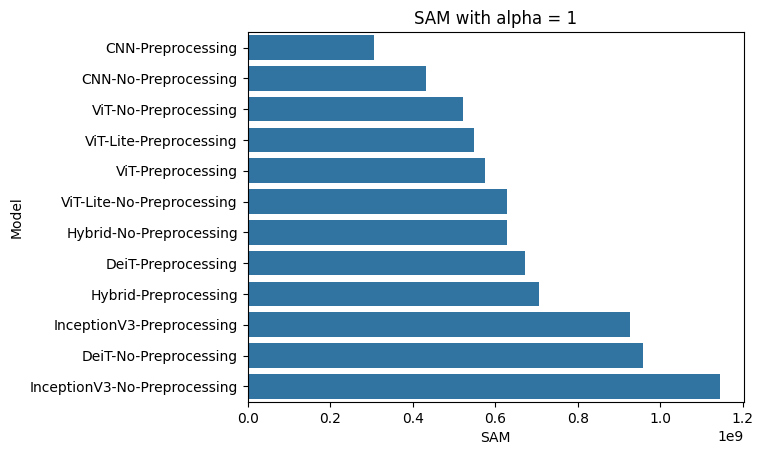

In [74]:
ax = sns.barplot(df_model_performance.sort_values(["SAM"]), x="SAM", y="Model", orient="y")
ax.set_title("SAM with alpha = 1")

- Log 10 of Energy Consumption in Ws

In [75]:
df_model_performance

,Model,EnergyConsumptionkWh,EnergyConsumptionWs,TrainAccuracy,TestAccuracy,TestF1,Epochs,Runtime,MaxStepRuntime,MinStepRuntime,IsPreprocessing,ModelName,AccuracyPerkWh,SAM,Avg. Duration/Epoch,RuntimeMinutes,Duration/Epoch
0,CNN-Preprocessing,0.002939,10581.273466,75.000000,65.753424,72.826087,26,147.048701,9 s,0 s,True,CNN,22370.873201,3.054048e+08,5 s,2 min 27 s,0 s - 5 s - 9 s
1,CNN-No-Preprocessing,0.003020,10870.958532,81.250000,70.547944,73.780488,30,168.792360,9 s,0 s,False,CNN,23362.484437,4.329541e+08,5 s,2 min 48 s,0 s - 5 s - 9 s
2,InceptionV3-Preprocessing,0.003731,13433.168713,84.375000,82.534248,82.105263,34,208.919632,9 s,0 s,True,InceptionV3,22118.630223,9.277106e+08,6 s,3 min 28 s,0 s - 6 s - 9 s
3,InceptionV3-No-Preprocessing,0.005099,18355.468447,87.500000,86.643833,87.043189,38,241.815092,9 s,0 s,False,InceptionV3,16993.181047,1.145236e+09,6 s,4 min 1 s,0 s - 6 s - 9 s
4,ViT-Preprocessing,0.019038,68536.894823,80.128894,77.397260,76.258993,24,353.168967,15 s,13 s,True,ViT,4065.403571,5.743127e+08,14 s,5 min 53 s,13 s - 14 s - 15 s
5,ViT-No-Preprocessing,0.015920,57310.734843,77.228786,75.684932,75.432526,21,328.052057,16 s,14 s,False,ViT,4754.183560,5.219166e+08,15 s,5 min 28 s,14 s - 15 s - 16 s
6,ViT-Lite-Preprocessing,0.002480,8926.477206,76.906552,73.630137,73.356401,20,85.760684,3 s,3 s,True,ViT-Lite,29694.636195,5.477800e+08,4 s,1 min 25 s,3 s - 4 s - 3 s
7,ViT-Lite-No-Preprocessing,0.003056,11001.929516,78.732546,76.027397,75.524476,36,147.879885,4 s,3 s,False,ViT-Lite,24877.329903,6.285088e+08,4 s,2 min 27 s,3 s - 4 s - 4 s
8,DeiT-Preprocessing,0.011416,41096.784500,83.673469,79.109589,78.136201,41,234.239841,5 s,4 s,True,DeiT,6929.849233,6.715620e+08,5 s,3 min 54 s,4 s - 5 s - 5 s
9,DeiT-No-Preprocessing,0.009148,32933.484063,86.251343,84.589041,84.210526,34,188.446577,6 s,4 s,False,DeiT,9246.533023,9.586479e+08,5 s,3 min 8 s,4 s - 5 s - 6 s


In [76]:
df_model_performance["EnergyConsumptionWs"] = np.log10(df_model_performance["EnergyConsumptionWs"])

In [77]:
df_model_performance["SAMNEW"] = df_model_performance["TestAccuracy"] / df_model_performance["EnergyConsumptionWs"]

In [78]:
df_model_performance["AccuracyRuntime"] = df_model_performance["TestAccuracy"] / np.log10(df_model_performance["Runtime"])

In [79]:
df_model_performance.head()

,Model,EnergyConsumptionkWh,EnergyConsumptionWs,TrainAccuracy,TestAccuracy,TestF1,Epochs,Runtime,MaxStepRuntime,MinStepRuntime,IsPreprocessing,ModelName,AccuracyPerkWh,SAM,Avg. Duration/Epoch,RuntimeMinutes,Duration/Epoch,SAMNEW,AccuracyRuntime
0,CNN-Preprocessing,0.002939,4.024538,75.000000,65.753424,72.826087,26,147.048701,9 s,0 s,True,CNN,22370.873201,3.054048e+08,5 s,2 min 27 s,0 s - 5 s - 9 s,16.338130,30.336610
1,CNN-No-Preprocessing,0.003020,4.036268,81.250000,70.547944,73.780488,30,168.792360,9 s,0 s,False,CNN,23362.484437,4.329541e+08,5 s,2 min 48 s,0 s - 5 s - 9 s,17.478509,31.673449
2,InceptionV3-Preprocessing,0.003731,4.128178,84.375000,82.534248,82.105263,34,208.919632,9 s,0 s,True,InceptionV3,22118.630223,9.277106e+08,6 s,3 min 28 s,0 s - 6 s - 9 s,19.992897,35.575425
3,InceptionV3-No-Preprocessing,0.005099,4.263765,87.500000,86.643833,87.043189,38,241.815092,9 s,0 s,False,InceptionV3,16993.181047,1.145236e+09,6 s,4 min 1 s,0 s - 6 s - 9 s,20.320966,36.351767
4,ViT-Preprocessing,0.019038,4.835924,80.128894,77.397260,76.258993,24,353.168967,15 s,13 s,True,ViT,4065.403571,5.743127e+08,14 s,5 min 53 s,13 s - 14 s - 15 s,16.004646,30.375899


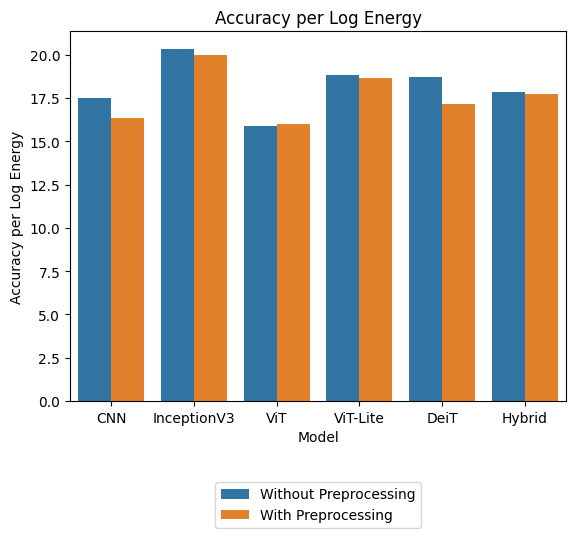

In [80]:
ax = sns.barplot(df_model_performance, x="ModelName", y="SAMNEW", hue="IsPreprocessing", orient="x")

# for container in ax.containers:
#     ax.bar_label(container, fmt='%.2f', fontsize=8)

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))

legend = ax.legend_
for text in legend.texts:
    if text.get_text() == "False":
        text.set_text("Without Preprocessing")
    elif text.get_text() == "True":
        text.set_text("With Preprocessing")

plt.ylabel("Accuracy per Log Energy")
plt.xlabel("Model")
plt.title("Accuracy per Log Energy")

plt.savefig("../images/AccuracyPerLogEnergy.png", dpi=600, bbox_inches="tight")

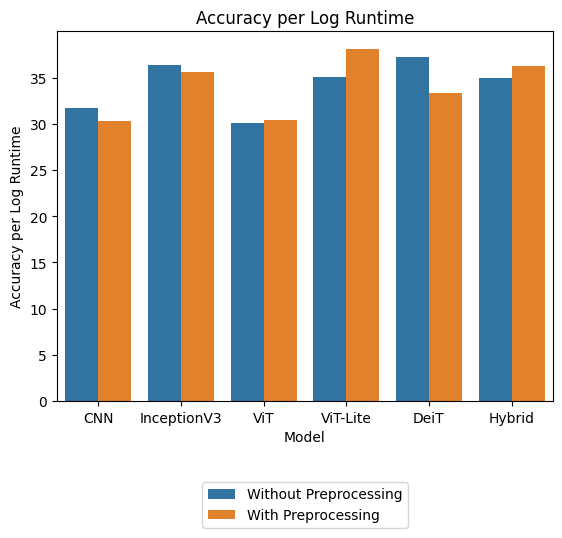

In [81]:
ax = sns.barplot(df_model_performance, x="ModelName", y="AccuracyRuntime", hue="IsPreprocessing", orient="x")

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2))

legend = ax.legend_
for text in legend.texts:
    if text.get_text() == "False":
        text.set_text("Without Preprocessing")
    elif text.get_text() == "True":
        text.set_text("With Preprocessing")

plt.ylabel("Accuracy per Log Runtime")
plt.xlabel("Model")
plt.title("Accuracy per Log Runtime")

plt.savefig("../images/AccuracyPerLogRuntime.png", dpi=600, bbox_inches="tight")

# Energy Consumption

## Test Accuracy vs Energy Consumption

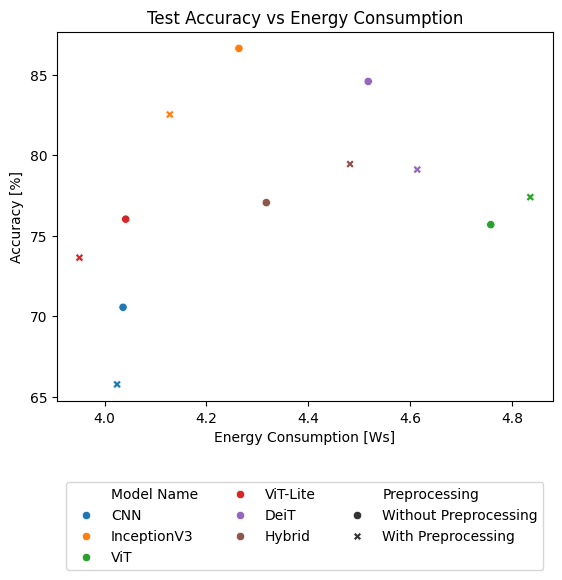

In [82]:
ax = sns.scatterplot(df_model_performance[["EnergyConsumptionWs", "TestAccuracy", "ModelName", "IsPreprocessing"]].rename(columns={"ModelName": "Model Name", "IsPreprocessing": "Preprocessing"}), x="EnergyConsumptionWs", y="TestAccuracy", hue="Model Name", style="Preprocessing")
ax.set_title("Test Accuracy vs Energy Consumption")
ax.set(xlabel="Energy Consumption [Ws]", ylabel="Accuracy [%]")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=3)

# Use Without Preprocessing instead of True
legend = ax.legend_
for text in legend.texts:
    if text.get_text() == "False":
        text.set_text("Without Preprocessing")
    elif text.get_text() == "True":
        text.set_text("With Preprocessing")

plt.savefig("../images/AccuracyPerEnergy.png", dpi=600, bbox_inches="tight")

## Epochs vs Energy Consumption

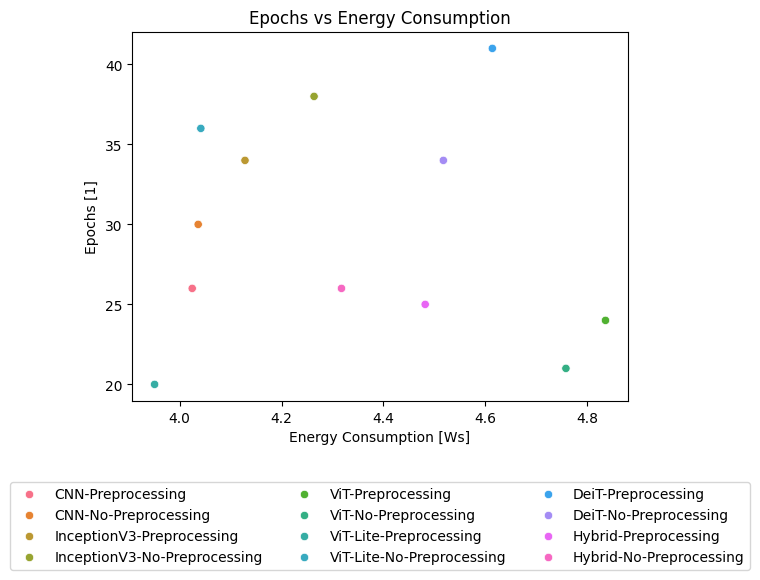

In [83]:
ax = sns.scatterplot(df_model_performance, x="EnergyConsumptionWs", y="Epochs", hue="Model")
ax.set_title("Epochs vs Energy Consumption")
ax.set(xlabel="Energy Consumption [Ws]", ylabel="Epochs [1]")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=3)

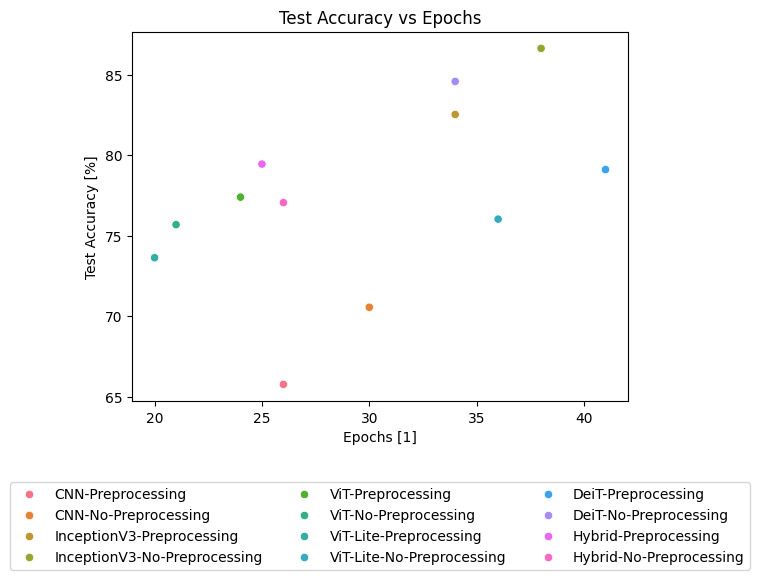

In [84]:
ax = sns.scatterplot(df_model_performance, x="Epochs", y="TestAccuracy", hue="Model")
ax.set_title("Test Accuracy vs Epochs")
ax.set(xlabel="Epochs [1]", ylabel="Test Accuracy [%]")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=3)

## Test Accuracy vs Runtime

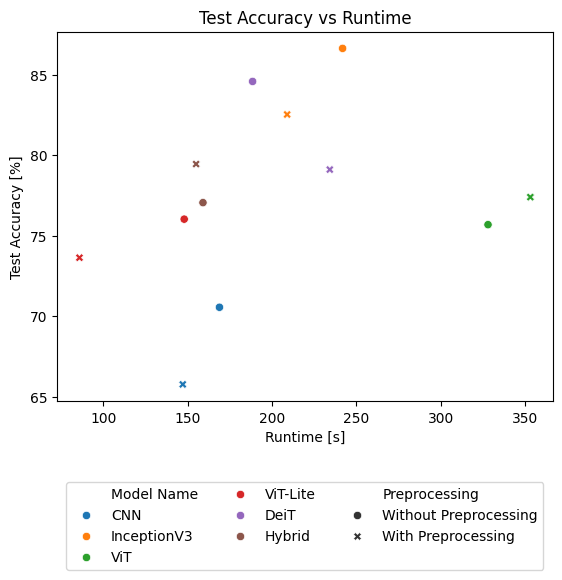

In [85]:
ax = sns.scatterplot(df_model_performance[["Runtime", "TestAccuracy", "ModelName", "IsPreprocessing"]].rename(columns={"ModelName": "Model Name", "IsPreprocessing": "Preprocessing"}), x="Runtime", y="TestAccuracy", hue="Model Name", style="Preprocessing")
ax.set_title("Test Accuracy vs Runtime")
ax.set(xlabel="Runtime [s]", ylabel="Test Accuracy [%]")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=3)

# Use Without Preprocessing instead of True
legend = ax.legend_
for text in legend.texts:
    if text.get_text() == "False":
        text.set_text("Without Preprocessing")
    elif text.get_text() == "True":
        text.set_text("With Preprocessing")

plt.savefig("../images/AccuracyPerSecond.png", dpi=600, bbox_inches="tight")

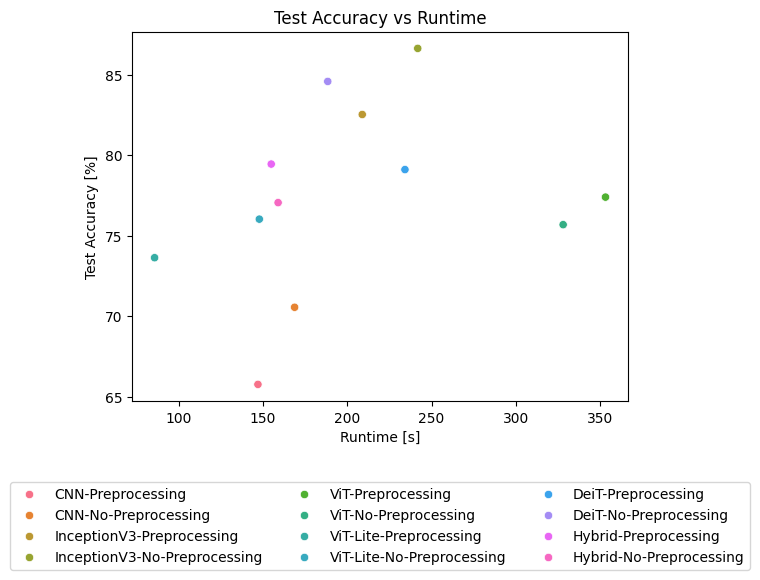

In [86]:
ax = sns.scatterplot(df_model_performance, x="Runtime", y="TestAccuracy", hue="Model")
ax.set_title("Test Accuracy vs Runtime")
ax.set(xlabel="Runtime [s]", ylabel="Test Accuracy [%]")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.savefig("../images/AccuracyPerSecond.png", dpi=600, bbox_inches="tight")